# Windstorm selection helper

- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [STORMS](https://github.com/CLIMAAX/STORMS) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

This notebook supports the [Hazard assessment for windstorms](Hazard_assessment_STORMS.ipynb): select storms based on proximity to a location of interest from a storm track database on CDS:
[Windstorm tracks and footprints derived from reanalysis over Europe between 1940 to present
](https://cds.climate.copernicus.eu/datasets/sis-european-wind-storm-reanalysis?tab=overview).


In [1]:
import pathlib
import io
import zipfile

import cdsapi
import earthkit.geo
import earthkit.plots
import numpy as np
import pandas as pd

## Preparation

Define the download folder:

In [2]:
data_dir = pathlib.Path("./STORM_event_raster")
data_dir.mkdir(parents=True, exist_ok=True)

# Where to download storm track dataset:
tracks_zip = data_dir / "windstorm_tracks_cds.zip"

## Step 1: Download storm track data

Retrieve the windstorm tracks from CDS. See the [CDS user guide](https://cds.climate.copernicus.eu/user-guide) for more information on data access. Skip this step if the file is already available at the location specified in `tracks_zip`.

In [ ]:
URL = "https://cds.climate.copernicus.eu/api"
KEY = None  # put your key if required

client = cdsapi.Client(url=URL, key=KEY)

tracks_zip = client.retrieve("sis-european-wind-storm-reanalysis", {
    "product": "windstorm_track",
    "variable": "all",
    "tracking_algorithm": ["hodges", "tempestextremes"],
    "event_aggregation": "all_events"
}).download(tracks_zip)

## Step 2: Read storm track data

There are two tracking algorithms used to define events in the database.
Both report the position of the storm as the locaiton of a mean sea level pressure minimum, but they differ in how they search for the minimum:

- `"hodges"`: identify 850 hPa relative vorticity maximum, then find mean sea level pressure minimum within a 5° radius.
- `"tempest_extremes"`: identify directly by mean sea level pressure minimum.

More information about the tracking algorithms can be found in the dataset's [product user guide](https://confluence.ecmwf.int/display/CKB/Windstorm+tracks+and+footprints+derived+from+reanalysis+over+Europe+between+1940+to+present%3A+Product+User+Guide#WindstormtracksandfootprintsderivedfromreanalysisoverEuropebetween1940topresent:ProductUserGuide-Trackingalgorithms).

In [3]:
tracking_algorithm = "hodges"

Read the table of storms for the selected tracking algorithm from the downloaded database:

In [4]:
def select_by_prefix(xs, prefix):
    for x in xs:
        if x.startswith(prefix):
            return x
    raise ValueError(f"No file found for prefix '{prefix}'")


with zipfile.ZipFile(tracks_zip) as archive:
    tracks_file = select_by_prefix(archive.namelist(), f"storm_track-{tracking_algorithm}-")
    with archive.open(tracks_file, "r") as f:
        storms = pd.read_csv(
            io.TextIOWrapper(f),
            index_col=["id", "time"],
            parse_dates=["time"]
        ).sort_index()

Preview of the table:

In [5]:
storms.head()

latitude  longitude       fg10  lsm        msl  \
id time                                                                  
1  1940-02-22 00:00:00     63.25     -24.00  10.452867  0.0  98962.875   
   1940-02-22 06:00:00     63.50     -25.00  12.599429  0.0  98905.190   
   1940-02-22 12:00:00     62.75     -11.25   5.919555  0.0  98809.125   
   1940-02-22 18:00:00     63.00     -12.00   7.741296  0.0  98755.560   
   1940-02-23 00:00:00     62.75     -12.25   4.190840  0.0  98655.310   

                       algorithm  
id time                           
1  1940-02-22 00:00:00    hodges  
   1940-02-22 06:00:00    hodges  
   1940-02-22 12:00:00    hodges  
   1940-02-22 18:00:00    hodges  
   1940-02-23 00:00:00    hodges

:::{tip}

You can explore the database here or filter it before continuing.
For example, you can select only storms that occurred after 2010 with:

```python
storms = storms.loc[storms.index.get_level_values("time") > pd.to_datetime("2010-01-01")]
```
:::

## Step 3: Order storms by distance to location

Define the coordinates of your location of interest (`lat`, `lon`):

In [6]:
lat = 52.012  # °N
lon =  4.359  # °E

Reorder the list of storms such that the geographically closest storms are at the top:

In [7]:
def minimum_distance(track):
    """Shortest distance between the storm track and the location of interest"""
    dist = earthkit.geo.distance.haversine_distance(
        [lat, lon],
        [track.loc[:,"latitude"], track.loc[:,"longitude"]]
    )
    return np.nanmin(dist)

# Add minimum distance of each storm track to the location of interest
# to the table, then sort the table so the closest storms are at the top
sorted_storms = (
    storms
    .join(
        storms
        .groupby("id")
        .apply(minimum_distance)
        .rename("min_distance")
    )
    .sort_values("min_distance")
)

:::{admonition} Caveat
:class: warning

The strength of the storm along the track is not taken into account in the `minimum_distance` function implemented here, only the geographical distance between the chosen location and the storm center at its closest point.
:::

In [8]:
sorted_storm_ids = list(sorted_storms.groupby("id", sort=False).groups.keys())

# The IDs of the ten closest storms
sorted_storm_ids[:10]

[358, 1616, 288, 1526, 1367, 426, 1366, 1484, 1549, 684]

## Step 4: Visualize tracks of closest storms

Display the tracks of the closest storms on a map together with the chosen location:

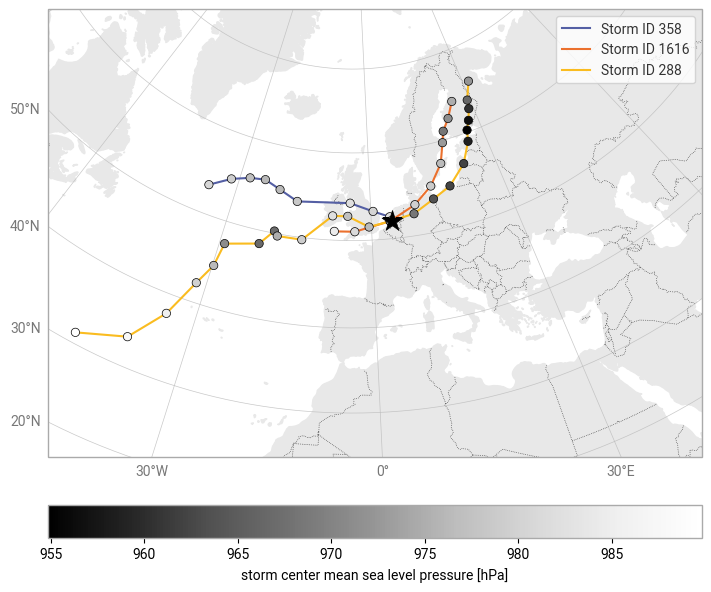

In [9]:
subplot = earthkit.plots.Map(domain=["North Atlantic", "Europe"])

# Marker for the location of interest
subplot.scatter(x=[lon], y=[lat], marker="*", c="black", s=250, zorder=10)

marker_x = []
marker_y = []
marker_c = []

# Number of storms to show
n = 3

for storm_id in sorted_storm_ids[:n]:
    storm_track = storms.loc[storm_id].sort_index()
    x = storm_track.loc[:,f"longitude"].values
    y = storm_track.loc[:,f"latitude"].values
    # Line for the track
    subplot.line(x=x, y=y, label=f"Storm ID {storm_id}", zorder=4)
    # Collect track information so storm strength markers can be plotted together
    # with a consistent colorscale
    marker_x.extend(x)
    marker_y.extend(y)
    marker_c.extend(storm_track.loc[:,"msl"] / 100)  # hPa
    n = n - 1
    if n == 0:
        break

# Markers indicating the value of reference variable to represent storm strength
sc = subplot.scatter(x=marker_x, y=marker_y, c=marker_c, marker="o", cmap="Greys_r", zorder=5)

subplot.fig.colorbar(sc, label=f"storm center mean sea level pressure [hPa]", orientation="horizontal")
subplot.ax.legend()

subplot.land()
subplot.borders()
subplot.gridlines()

Lower values of mean sea level pressure generally indicate a stronger storm.

## Step 5: Find the corresponding storm(s) on CDS

To download the gridded storm footprint for a storm from the tracks database, the date under which the data has been filed on CDS must be found.
It is *usually* the date at which the storm is first tracked.

In [10]:
storm_id = 358

storms.loc[storm_id]  # enter a storm ID to see the data for the corresponding track

,latitude,longitude,fg10,lsm,msl,algorithm
time,,,,,,
1958-12-09 12:00:00,53.25,-36.00,16.655293,0.000000,98054.375,hodges
1958-12-09 18:00:00,54.75,-31.75,17.521915,0.000000,97930.000,hodges
1958-12-10 00:00:00,55.50,-27.75,14.142773,0.000000,97696.625,hodges
1958-12-10 06:00:00,55.75,-24.25,13.544517,0.000000,97608.560,hodges
1958-12-10 12:00:00,55.00,-20.50,11.378557,0.000000,97627.625,hodges
1958-12-10 18:00:00,54.00,-16.25,9.302895,0.000000,97836.560,hodges
1958-12-11 00:00:00,54.25,-4.50,9.535096,0.207638,98216.875,hodges
1958-12-11 06:00:00,53.25,0.50,11.224004,0.167126,98017.190,hodges
1958-12-11 12:00:00,52.50,4.00,11.516340,0.000000,98184.375,hodges


Use the [data selection interface](https://cds.climate.copernicus.eu/datasets/sis-european-wind-storm-reanalysis?tab=download) on the CDS website to configure the request interactively or try the following request directly in the [Hazard assessment for windstorms](Hazard_assessment_STORMS.ipynb).

In [11]:
date = storms.loc[storm_id].index.min()

# Generate a CDS request for a downscaled footprint of selected storm:
# 1. set selected tracking algorithm
# 2. choose likely date based on track start time
print(f"""
import cdsapi

dataset = "sis-european-wind-storm-reanalysis"
request = {{
    "product": "windstorm_footprint",
    "variable": "all",
    "tracking_algorithm": ["{tracking_algorithm.replace('_', '')}"],
    "event_aggregation": "single_event",
    "windstorm_footprint_resolution": "downscaled",
    "spatial_extent": "windstorm_footprint_area",
    "year": ["{date.year}"],
    "month": ["{date.month:0>2}"],
    "day": ["{date.day:0>2}"]
}}

client = cdsapi.Client()
client.retrieve(dataset, request).download()
""")


import cdsapi

dataset = "sis-european-wind-storm-reanalysis"
request = {
    "product": "windstorm_footprint",
    "variable": "all",
    "tracking_algorithm": ["hodges"],
    "event_aggregation": "single_event",
    "windstorm_footprint_resolution": "downscaled",
    "spatial_extent": "windstorm_footprint_area",
    "year": ["1958"],
    "month": ["12"],
    "day": ["09"]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()



:::{important}
When loading the downloaded storm footprint, confirm that the `track_id` in the dataset is the same as your expected storm ID.
If not, use the interactive request page on CDS to find data from nearby dates and try these as well.
:::